In [1]:
import numpy as np
from scipy import sparse
from scipy import stats
from scipy.optimize import minimize
from tqdm.auto import tqdm
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

### Reservior computer setup

In [2]:
class RC:
    """

    A class which implements a reservoir computing framework for data forecasting.

    A default initialization creates a classical reservoir computer with a tanh input nonlinearity
    and a linear output map.
    x(t+1) = (1 - alpha)*x + alpha*f(Ax(t) + Bu(t) + b)
    y(t) = Cx(t)
    Attributes:
    -----------
    Nx: integer dimension of reservoir
    Nu: integer dimension of input
    f: input activation function; tanh unless otherwise defined
    A: Nx by Nx array, reservoir weights
    B: Nx by Nu array, input weights
    b: Nx by 1 array, bias
    sigma: positive scalar, range of values for B matrix [-sigma, sigma]
    alpha: positive scalar, time scale of reservoir
    rho_sr: positive scalar, spectral radius of reservoir (used to construct A matrix)
    sigma_b: positive scalar, strength of bias in reservoir
    rho_A: positive scalar in (0,1], density of connections in A
    beta: Tikhonov regularization parameter
    Forecasting: True or False, internal flag
    Training: True or False, internal flag
    x: Nx by 1 array, current reservoir state
    t: integer, current time step
    xt: Nx by Nt array, state history during training
    xf: Nx by Nf array, state history during forecasting
    p_form: string, form of input weights ("linear" or "quadratic")
    add_LS_bias: True or False, flag for adding bias to readout vector in least squares problem (default is False)

    Methods:
    -----------
    StepForward(u_k)
        Evolve the reservoir one time step forward
    Train_Traj(U, lambd = 1e-6, quadratic = False)
        Train the output weights given the time history of inputs
    Forecast_Traj(K)
        Forecast the time history of outputs for K time steps forward given the time history of inputs up through current time step
    build_A()
        Construct the reservoir weight matrix A
    build_B()
        Construct the input weight matrix B
    get_p()
        Construct the observation vector p used in forecasting and training

    Authors: Anastasia Bizyaeva, Jan Williams
    e-mail: anabiz@uw.edu

    """

    def __init__(self, Nx=200, Nu=3, f=np.tanh, A = 0, B = 0, sigma = 0.084, alpha = 0.6, rho_sr=0.80, sigma_b=1.6, rho_A=0.02, beta=8.493901e-8,leak =1.0, p_form = "linear", add_LS_bias = False,):

        """

        Initialize a ReservoirComputer instance.

            Attributes:
            -----------
            Nx: integer dimension of reservoir
            Nu: integer dimension of input
            f: input activatiion function; tanh unless otherwise defined
            g: output activation function; g(x) = x unless otherwise defined
            A: Nx by Nx array, reservoir weights; randomly generated if not provided
            B: Nx by Nu array, input weights; randomly generated if not provided
            b: Nx by 1 array, bias added inside reservoir
            alpha: positive scalar, time step of reservoir
            rho_sr: positive scalar, spectral radius of absolute value of reservoir (used to construct A matrix)
            sigma: positive scalar, range of input weights [-sigma,sigma] used to generate B matrix
            sigma_b: positive scalar, scaling factor of bias (used to construct b vector)
            rho_A: scalar in [0,1] interval, probability of connection between reservoir nodes
            Forecasting: True or False, internal flag
            Training: True or False, internal flag
            x: Nx by 1 array, current reservoir state
            t: integer, current time step
            xt: Nx by Nt array, reservoir state history during training (initiated with initial condition)
            xf: Nx by Nf array, reservoir state history during forecasting (initiated empty)
            p_form: string, form of input weights ("linear" or "quadratic") - default "linear"
            add_LS_bias: True or False, flag for adding a random bias to readout vector in least squares (default is False)
            leak: leak rate of reservoir
        """

        self.Nx = Nx
        self.Nu = Nu
        self.f = f
        self.sigma = sigma
        self.alpha = alpha
        self.rho_sr = rho_sr
        self.sigma_b = sigma_b
        self.rho_A = rho_A
        self.beta = beta
        self.Forecasting = False
        self.Training = False
        self.p_form = p_form
        self.add_LS_bias = add_LS_bias
        self.x = np.zeros([self.Nx,1])
        self.leak=leak

        if isinstance(A,int):            # reservoir weights (initialized randomly when not user-supplied)
            # construct A matrix

            # generate sparse random matrix of size Nx by Nx with connection density rho_A
            A = self.build_A()

            # check if A is full rank, if not repeat until it is
            while_count = 0
            while np.linalg.matrix_rank(A) < Nx:
                A = self.build_A()
                while_count+=1
                if while_count > 10: # if A is not full rank after 10 tries, break and use A as is
                    print('Warning: A matrix is not full rank')
                    break
            self.A = A

        else:
            # A matrix is user-supplied

            # Check that A is a square matrix of size Nx by Nx
            if A.shape[0] != Nx or A.shape[1] != Nx:
                raise ValueError("A is not a square matrix of size Nx by Nx")
            else:
                self.A = A
        # input weights (initialized randomly when not user-supplied)
        # initialize B to be a random dense matrix of size Nx by Nu with uniformly distributed entries between -sigma and sigma
        if isinstance(B,int):

            B = self.build_B()
            self.B = B

        else:
            # Check that B is a square matrix of size Nx by Nu
            if B.shape[0] != Nx or B.shape[1] != Nu:
                raise ValueError("B is not a square matrix of size Nx by Nu")
            else:
                self.B = B

        self.t = 0                                          # initial time step
        #self.xt =np.array(self.x)                           # state history during training: add initial condition as first row of array
        #self.xf = np.empty((self.Nx,1),dtype=np.float64)    # state history during forecasting

        self.b = self.sigma_b * np.ones([self.Nx,1])        # construct bias vector

        self.train_counter = 0
        self.forecast_counter = 0


    def build_A(self):
        """
        Build a sparse random matrix A with connection density rho_A and spectral radius rho_sr
        Outputs:
        -----------
        A: Nx by Nx numpy array, sparse random matrix with density rho_A and spectral radius rho_sr
        """
        A = np.random.uniform(-1,1,size=self.Nx ** 2)
        del_indices = np.random.choice(self.Nx ** 2, size=int((1-self.rho_A)*self.Nx ** 2),replace=False)
        A[del_indices] = 0
        A = A.reshape(self.Nx, self.Nx)
        A = A*(self.rho_sr/np.max(np.abs(np.linalg.eigvals(A))))

        return A

    def build_B(self):
        """
        Build an input matrix B with entries chosen uniformly [-sigma, sigma]
        Outputs:
        -----------
        B: Nx by Nu numpy array, random input matrix mapping from dim(Nu) to dim(Nx)
        """
        B = np.random.uniform(-self.sigma, self.sigma, size=(self.Nx, self.Nu))
        return B


    def StepForward(self,u_k, i=None):
        """
        Advance the reservoir state one time step according to x(t+1) = (1-alpha)x(t) + alpha*tanh(Ax(t) + Bu(t) + b)
            Inputs:
            -----------
            u_k: Nu by 1 vector of inputs to the reservoir at the current time step
        """
        if u_k.shape[0] != self.Nu:
            raise ValueError("Input u_k is not a vector of length Nu")
        else:
            if u_k.ndim == 1:
                u_k = u_k.reshape(self.Nu,1) # convert u_k to a column vector

            self.x = (1 - self.alpha*self.leak)*self.x + self.alpha * self.f(self.A.dot(self.x) + self.B.dot(u_k) + self.b)         # update reservoir state taking one step forward

            if self.Training:
                self.xt[:, self.train_counter:1+self.train_counter] = self.x
                self.train_counter += 1
                #self.xt = np.concatenate((self.xt,self.x),axis=1)         # add current reservoir state to training history
            if self.Forecasting:
                self.xf[:, self.forecast_counter:1+self.forecast_counter] = self.x
                self.forecast_counter += 1
                #self.xf = np.concatenate((self.xf,self.x),axis=1)         # add current reservoir state to forecasting history
            self.t +=1

    def get_p(self,x_t):
        """

        Compute the parameter vector used in least squares problem in reservoir training and in forecasting

            Inputs:
            -----------
            x_t: either Nt by Nx array(reservoir state history) or Nx-element 1d array (reservoir state at a particular time step)
            Returns:
            -----------
            p: numpy array, parameter vector used in least squares problem in reservoir training and in forecasting

        """
        # check that input is a 2d array
        if x_t.ndim != 2:
            raise ValueError("Input must be a 2d array")


        Nt = x_t.shape[1] # number of time steps

        if self.p_form == "linear":
            p = x_t
        if self.p_form == "quadratic":
            p = np.concatenate((x_t,np.square(x_t)),axis = 0)
        if self.add_LS_bias:
            p = np.concatenate((np.ones([1,Nt]),p),axis = 0)

        return p



    def Train_Traj(self,U,trainl,step, spinup=500,verbose=False):
        """

        Train the output weights given the time history of inputs up through current time step

            Inputs:
            -----------
            U: 2darray with dimension Nu by Nt, time history of input for training
            lambd: regularization coefficient for pseudoinverse; prevents ill-conditioning of weights from overfitting

        """
        if U.shape[0] != self.Nu:
            raise ValueError("U is not a matrix of size Nu by number of training time steps")
        else:
            for i in range(spinup):
                self.StepForward(U[:,i])

            self.Training = True

            self.xt = np.zeros([self.Nx, len(U[0,spinup+1:])])
            # assert self.xt.shape[1] == 14499, "shape should in 14500"

            if verbose == False:
                for i in range(spinup,U.shape[1] - 1):
                    self.StepForward(U[:,i])
                    if np.linalg.norm(self.x) > 1e10 or np.isnan(np.linalg.norm(self.x)):
                        print('Reservoir trajectory blew up after '+str(i)+' steps in training')
                        self.Training = False # turn off training flag
                        break
            if verbose == True:
                clear_output(wait=True)
                for i in tqdm(range(spinup,U.shape[1] - 1)):
                    self.StepForward(U[:,i])
                    if np.linalg.norm(self.x) > 1e10 or np.isnan(np.linalg.norm(self.x)):
                        print('Reservoir trajectory blew up after '+str(i)+' steps in training')
                        self.Training = False # turn off training flag
                        break
            
            x_mat = self.get_p(self.xt)
            u_mat = U[:, spinup+1:]
            # print(x_mat.shape, u_mat.shape)
            
            self.C0 = []
            self.xt0 = []
            for i in range(int(trainl/step)):
                x_matn = x_mat[:, 0:(i+1)*step]
                u_matn = U[:, spinup+1:spinup+1+(i+1)*step]
                lhs = (x_matn.dot(x_matn.T) + self.beta * np.eye(self.Nx))
                rhs = x_matn.dot(u_matn.T)
                C_mat_Tn = np.linalg.lstsq(lhs, rhs, rcond=None)[0]
                self.C0.append(C_mat_Tn.T)
                self.xt0.append(self.xt)
            
            # train output weights using regularized least squares            
            lhs = (x_mat.dot(x_mat.T) + self.beta * np.eye(self.Nx))
            rhs = x_mat.dot(u_mat.T)
            C_mat_T = np.linalg.lstsq(lhs, rhs, rcond=None)[0]
            self.C = C_mat_T.T

            # print(np.sum((self.C0[-1] - self.C)**2))

        self.Training = False

    def Forecast_Traj(self,K, spinup_data = None,verbose=False):
        """

        Assuming reservoir has been trained, forecast the trajectory forward in time

            Inputs:
            -----------
            K: integer, number of time steps for forward forecasting

        """

        ### forecast from the existing internal reservoir state x
        if spinup_data is not None:
            self.Training = False
            self.Forecasting = False
            self.x = np.zeros([self.Nx,1])
            for i in range(spinup_data.shape[1]):
                self.StepForward(spinup_data[:,i])

        self.Forecasting = True
        self.forecast_counter = 0
        self.xf = np.zeros([self.Nx, K])
        if verbose == False:
            for i in range(K):
                p = self.get_p(self.x)
                temp_u = self.C.dot(p)
                self.StepForward(temp_u)
                if np.linalg.norm(self.x) > 1e10 or np.isnan(np.linalg.norm(self.x)):
                        print('Forecasted trajectory blew up after '+str(i)+' steps')
                        self.Forecasting = False # turn off forecasting flag
                        break
        if verbose == True:
            for i in tqdm(range(K)):
                p = self.get_p(self.x)
                temp_u = self.C.dot(p)
                self.StepForward(temp_u)
                if np.linalg.norm(self.x) > 1e10 or np.isnan(np.linalg.norm(self.x)):
                        print('Forecasted trajectory blew up after '+str(i)+' steps')
                        self.Forecasting = False # turn off forecasting flag
                        break

        self.Forecasting = False

### TODO: Investigate computational speedups/parallelization for the optimization routine

### Dynamical systems as training data

In [ ]:
# Lorenz
from dysts.flows import Lorenz

model = Lorenz()
sol = model.make_trajectory(20000, pts_per_period=100, return_times=True)
U = sol[1].T
print(U.shape)

dt_data = sol[0][1]
T = sol[0][-1]
print(dt_data, T)

In [ ]:
# Lorenz96
from dysts.flows import Lorenz96

model = Lorenz96()
sol = model.make_trajectory(20000, pts_per_period=100, return_times=True)
U = sol[1].T
print(U.shape)

dt_data = sol[0][1]
T = sol[0][-1]
print(f'T = {T}, dt = {dt_data}')

In [ ]:
# Rossler
from dysts.flows import Rossler

model = Rossler()
sol = model.make_trajectory(20000, pts_per_period=100, return_times=True)
U = sol[1].T
print(U.shape)

dt_data = sol[0][1]
T = sol[0][-1]
print(dt_data, T)

In [9]:
# Double Pendulum
'''
from dysts.flows import DoublePendulum

model = DoublePendulum()
sol = model.make_trajectory(20000, pts_per_period=100, return_times=True)
U = sol[1].T
print(U.shape)

dt_data = sol[0][1]
T = sol[0][-1]
print(dt_data, T)
'''


def DoublePendulum(t, x, d=1, m=1):
        
    th1, th2, p1, p2 = x[0], x[1], x[2], x[3]

    g = 9.82
    pre = 6 / (m * d ** 2)
    denom = 16 - 9 * np.cos(th1 - th2) ** 2
    th1_dot = pre * (2 * p1 - 3 * np.cos(th1 - th2) * p2) / denom
    th2_dot = pre * (8 * p2 - 3 * np.cos(th1 - th2) * p1) / denom
    p1_dot = (-0.5 * (m * d ** 2) * (th1_dot * th2_dot * np.sin(th1 - th2) + 3 * (g / d) * np.sin(th1)))
    p2_dot = (-0.5 * (m * d ** 2) * (-th1_dot * th2_dot * np.sin(th1 - th2) + 3 * (g / d) * np.sin(th2)))
    return np.array([th1_dot, th2_dot, p1_dot, p2_dot])


In [78]:
# Dadras
'''
from dysts.flows import Dadras

model = Dadras()
sol = model.make_trajectory(20000, pts_per_period=100, return_times=True)
U = sol[1].T
print(U.shape)

dt_data = sol[0][1]
T = sol[0][-1]
print(dt_data, T)
'''

def Dadras(t, x, c=2, e=9, o=2.7, p=3, r=1.7):
    xdot = x[1] - p * x[0] + o * x[1] * x[2]
    ydot = r * x[1] - x[0] * x[2] + x[2]
    zdot = c * x[0] * x[1] - e * x[2]
    
    return np.array([xdot, ydot, zdot])

In [3]:
# Blasius
def Blasius(t, x, a = 1, alpha1 = 0.2, alpha2 = 1, b = 1, c = 10, k1 = 0.05, k2 = 0, zs = 0.006):
    xdot = a * x[0] - alpha1 * x[0] * x[1] / (1 + k1 * x[0])
    ydot = -b * x[1] + alpha1 * x[0] * x[1] / (1 + k1 * x[0]) - alpha2 * x[1] * x[2] / (1 + k2 * x[1])
    zdot = -c * (x[2] - zs) + alpha2 * x[1] * x[2] / (1 + k2 * x[1])
    return np.array([xdot, ydot, zdot])


In [ ]:
# Chen
def Chen(t, v, a=35, b=3, c=28):
    x, y, z = v[0], v[1], v[2]
    xdot = a * y - a * x
    ydot = (c - a) * x - x * z + c * y
    zdot = x * y - b * z
    return np.array([xdot, ydot, zdot])


In [ ]:
#YuWang
def YuWang(t, x, a=10, b=40, c=2, d=2.5):
    xdot = a * (x[1] - x[0])
    ydot = b * x[0] - c * x[0] * x[2]
    zdot = np.exp(x[0] * x[1]) - d * x[2]
    return np.array([xdot, ydot, zdot])

In [4]:
# BurkeShaw
def BurkeShaw(t, v, e = 13, n = 10):
    x, y, z = v[0], v[1], v[2]
    xdot = -n * x - n * y
    ydot = y - n * x * z
    zdot = n * x * y + e
    return np.array([xdot, ydot, zdot])


In [3]:
def Rossler(t, v, a=0.2, b=0.2, c=5.7):
    xdot = -v[1] - v[2]
    ydot = v[0] + a * v[1]
    zdot = b + v[2] * v[0] - c * v[2]
    return np.array([xdot, ydot, zdot])


### Training

In [4]:
'''Nx: integer dimension of reservoir
    Nu: integer dimension of input
    f: input activation function; tanh unless otherwise defined
    A: Nx by Nx array, reservoir weights
    B: Nx by Nu array, input weights
    b: Nx by 1 array, bias
    sigma: positive scalar, range of values for B matrix [-sigma, sigma]
    alpha: positive scalar, leak rate of reservoir
    rho_sr: positive scalar, spectral radius of reservoir (used to construct A matrix)
    sigma_b: positive scalar, strength of bias in reservoir
    rho_A: positive scalar in (0,1], density of connections in A'''

# Nx=200; Nu=3; f=np.tanh; sigma=0.084; alpha=0.6; rho_sr=0.8; sigma_b=1.6; rho_A=0.1; beta=8.493901e-8;
# Nx=200; Nu=3; f=np.tanh; sigma=0.084; alpha=0.1; rho_sr=0.8; sigma_b=1.6; rho_A=0.1; beta=8.493901e-8;
Nx=200; Nu=3; f=np.tanh; sigma=0.277254; alpha=0.0711564; rho_sr=0.95089; sigma_b=1.47935; rho_A=0.984754; beta=1e-06;

rc = RC(Nx=Nx, Nu=3, f=f, A=0, B=0, sigma=sigma, alpha=alpha, rho_sr=rho_sr, sigma_b=sigma_b, rho_A=rho_A, beta=beta, p_form = "linear", add_LS_bias = False)

In [6]:
# np.save("A_init_BS.npy", rc.A)
#np.save("B_init_BS.npy", rc.B)

In [7]:
train_len = 14500 # number of samples to use in training
sp = 500 # number of transient points to discard at the beginning
sampr = 100
rc.Train_Traj(U[:,:train_len],train_len - sp,sampr, spinup = sp)

NameError: name 'U' is not defined

In [ ]:
# visualize what's happening during training

y = rc.C.dot(rc.get_p(rc.xt))
t = np.linspace(0, (train_len-sp-1)*dt_data, train_len-sp-1)

#forecasted_traj = rc.C.dot(rc.get_p(rc.xf))
fig, ax = plt.subplots(3,1,figsize=(8,6))
fig.suptitle('Training on L63, Nr = '+str(Nx), fontsize=16)

# plot vertical gray line at train_t_spinup
ax[0].plot(t, y[0,:], 'b-', linewidth=2, label='Trained output')
ax[0].plot(t, U[0,sp:train_len-1], 'k-', linewidth=2, label='L63')
ax[0].set_xlabel('$\lambda_1 t$')
ax[0].set_ylabel('$x$')

ax[1].plot(t, y[1,:], 'b-', linewidth=2)
ax[1].plot(t, U[1,sp:train_len-1],'k--',linewidth=2)
ax[1].set_xlabel('$\lambda_1 t$')
ax[1].set_ylabel('$y$')

ax[2].plot(t, y[2,:], 'b-', linewidth=2)
ax[2].plot(t, U[2,sp:train_len-1], 'k--',linewidth=2)
ax[2].set_xlabel('$\lambda_1 t$')
ax[2].set_ylabel('$z$')
plt.tight_layout()
ax[0].legend(loc='upper right')
plt.show()

In [ ]:
xstore = rc.x
orgin_c = rc.C

In [ ]:
#Calculating MSE in training

train_loss = []

samps = int((train_len-sp)/sampr)
for j in range(samps):
    y = rc.C0[j].dot(rc.get_p(rc.xt0[j]))

    mse = np.mean((U[0,sp:train_len-1] - y[0, :])**2)
    train_loss.append(mse)

plt.plot(range(samps), train_loss)

### Forecasting

In [ ]:
forecast_len = 4000 # number of time steps to forecast
# rc.Forecast_Traj(forecast_len)

samps = int((train_len-sp)/sampr)
ftlist = []
Mlist = []
for j in range(samps):
    rc.x = xstore
    rc.C = rc.C0[j]
    rc.Forecast_Traj(forecast_len)
    ftlist.append(rc.C.dot(rc.get_p(rc.xf)))
    Mlist.append(rc.A+rc.B.dot(rc.C))


In [ ]:
forecasted_traj = ftlist[-1]
t = np.linspace(0, forecast_len*dt_data, forecast_len) * 0.9 ### characteristic Lyapunov timescale, 0.9 = lambda1 the largest Lyapunov exponent
fig, ax = plt.subplots(3,1,figsize=(8,6))
fig.suptitle('Forecasting L63, Nr = '+str(rc.Nx), fontsize=16)

ax[0].plot(t, U[0, train_len:train_len+forecast_len], 'k-', linewidth=3, label='Truth')
ax[0].plot(t, forecasted_traj[0,:],'r--', linewidth=2, label='Forecast')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
#ax[0].set_ylim([-20,20])

ax[1].plot(t, U[1, train_len:train_len+forecast_len], 'k-', linewidth=3)
ax[1].plot(t, forecasted_traj[1,:],'r--',linewidth=2)
ax[1].set_xlabel('$ t$')
ax[1].set_ylabel('$y$')

ax[2].plot(t, U[2, train_len:train_len+forecast_len], 'k-', linewidth=3)
ax[2].plot(t, forecasted_traj[2,:],'r--',linewidth=2)

ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$z$')
plt.tight_layout()
ax[0].legend()

plt.show()

### Finding Forecast Horizon

In [4]:
def smape():
    error = np.zeros(len(t))
    for i in range(len(t)):
        error[i] = 2*np.sum(abs(U[0, train_len:train_len+i] - forecasted_traj[0, 0:i])/abs(U[0, train_len:train_len+i] + forecasted_traj[0, 0:i]))*(t[1] - t[0])/(t[i]-t[0])
    return error

'''
smapeerror = smape()
plt.plot(t, smapeerror, label = "sMAPE")
plt.xlabel("$t$", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend(fontsize=12)
''' 

def nrmse():
    error = np.zeros(len(t))
    inner = (U[0, train_len:train_len+forecast_len] - forecasted_traj[0, :])**2
    sig = np.std(U[0, :])
    for i in range(len(t)):
        error[i] = np.sqrt((np.sum(inner[0:i]/sig**2))/(t[i]-t[0]))
    return error

'''
nrmseerror = nrmse()
plt.figure()
plt.plot(t, nrmseerror, label="NRMSE")
plt.xlabel("$t$", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend(fontsize=12)
'''

'\nnrmseerror = nrmse()\nplt.figure()\nplt.plot(t, nrmseerror, label="NRMSE")\nplt.xlabel("$t$", fontsize=12)\nplt.ylabel("Error", fontsize=12)\nplt.legend(fontsize=12)\n'

In [ ]:
a = []
for i in range(samps):
    forecasted_traj = ftlist[i]
    a.append(np.sum(np.sqrt((U[0, train_len:train_len+forecast_len] -  forecasted_traj[0,:] ) ** 2)))

# plt.scatter(range(29), a)

forecast_h = np.zeros(samps)
for i in range(samps):
    forecasted_traj = ftlist[i]
    smapeerror = smape()
    for j in range(len(smapeerror)):
        if smapeerror[j] >= 0.1: # this number is arbitary at the moment
            forecast_h[i] = t[j]
            break

print(forecast_h)
plt.plot(np.array(range(samps))*sampr, forecast_h, marker = '.', markersize = 10)
plt.xlabel("Size of Training Data Sets", fontsize = 11)
plt.ylabel("Accurate Forecast Horizon (sMAPE)", fontsize = 11)
# plt.xlim(0, 2000)
plt.grid()

In [14]:
import time
start_time = time.time()

train_len = 2000 # number of samples to use in training
sp = 50 # number of transient points to discard at the beginning
sampr = 50

# Averange Error Trend in Training
samps = int((train_len-sp)/sampr)
n_train = 100
avg_mse = np.zeros((n_train, samps))
avg_forecasth = np.zeros((n_train, samps))

for k in range(n_train):
    
    # Generating training data
    
    '''
    model = Dadras()
    model.ic = 2*np.random.randn(3)
    sol = model.make_trajectory(20000, pts_per_period=200, return_times=True)
    U = sol[1].T

    dt_data = sol[0][1]
    T = sol[0][-1]
    '''
    T = 300
    dt_data = 0.05
    # x0 = 2*np.random.randn(3)

    x0 = np.array([6.5134412, 0.4772013, 0.34164294])
    perturbations = np.random.normal(loc=0, scale=0.1, size=3)
    x0 = x0 + perturbations
    
    xt_blasius = integrate.solve_ivp(Rossler, [0, T], x0, method='RK45', t_eval=np.arange(0, T, dt_data), rtol=1e-12)
    U = xt_blasius.y 
    
    # Training
    # Nx=200; Nu=3; f=np.tanh; sigma=0.084; alpha=0.1; rho_sr=0.8; sigma_b=1.6; rho_A=0.1; beta=8.493901e-8;
    Nx=200; Nu=3; f=np.tanh; sigma=0.066; alpha=0.47; rho_sr=0.5; sigma_b=1.23; rho_A=0.98; beta=2.101845e-9;
    A0 = np.load("A_init_BS.npy")
    B0 = np.load("B_init_BS.npy")
    
    rc = RC(Nx=Nx, Nu=3, f=f, A=A0, B=B0, sigma=sigma, alpha=alpha, rho_sr=rho_sr, sigma_b=sigma_b, rho_A=rho_A, beta=beta, p_form = "linear", add_LS_bias = False)

    rc.Train_Traj(U[:,:train_len],train_len - sp,sampr, spinup = sp)
    xstore1 = rc.x

    train_loss = []

    for j in range(samps):
        y = rc.C0[j].dot(rc.get_p(rc.xt0[j]))

        mse = np.mean((U[0,sp:train_len-1] - y[0, :])**2)
        train_loss.append(mse)

    avg_mse[k] = np.array(train_loss)

    # Forecasting
    forecast_len = 2000
    t = np.linspace(0, forecast_len*dt_data, forecast_len) * 0.9

    samps = int((train_len-sp)/sampr)
    ftlist = []
    Mlist = []
    for j in range(samps):
        rc.x = xstore1
        rc.C = rc.C0[j]
        rc.Forecast_Traj(forecast_len)
        ftlist.append(rc.C.dot(rc.get_p(rc.xf)))
        Mlist.append(rc.A+rc.B.dot(rc.C))
    
    a = []
    for i in range(samps):
        forecasted_traj = ftlist[i]
        a.append(np.sum(np.sqrt((U[0, train_len:train_len+forecast_len] -  forecasted_traj[0,:] ) ** 2)))

    forecast_h = np.zeros(samps)
    for i in range(samps):
        forecasted_traj = ftlist[i]
        smapeerror = smape()
        for j in range(len(smapeerror)):
            if smapeerror[j] >= 0.1: # this number is arbitary at the moment
                forecast_h[i] = t[j]
                break
            forecast_h[i] = t[-1]
    
    avg_forecasth[k] = forecast_h
    
    print(f"Loop {k}", "--- %s seconds ---" % (time.time() - start_time))


/tmp/ipykernel_275592/668786381.py:4: RuntimeWarning: invalid value encountered in scalar divide
  error[i] = 2*np.sum(abs(U[0, train_len:train_len+i] - forecasted_traj[0, 0:i])/abs(U[0, train_len:train_len+i] + forecasted_traj[0, 0:i]))*(t[1] - t[0])/(t[i]-t[0])


Loop 0 --- 39.6662073135376 seconds ---
Loop 1 --- 53.867318868637085 seconds ---
Loop 2 --- 72.85967087745667 seconds ---
Loop 3 --- 91.09604382514954 seconds ---
Loop 4 --- 123.04180216789246 seconds ---
Loop 5 --- 157.28679966926575 seconds ---
Loop 6 --- 179.14923787117004 seconds ---
Loop 7 --- 212.02454113960266 seconds ---
Loop 8 --- 242.79926919937134 seconds ---
Loop 9 --- 267.0479407310486 seconds ---
Loop 10 --- 279.5132966041565 seconds ---
Loop 11 --- 311.2524063587189 seconds ---
Loop 12 --- 334.39205861091614 seconds ---
Loop 13 --- 349.86553406715393 seconds ---
Loop 14 --- 369.78733015060425 seconds ---
Loop 15 --- 388.69756054878235 seconds ---
Loop 16 --- 410.09036087989807 seconds ---
Loop 17 --- 425.4254846572876 seconds ---
Loop 18 --- 439.7421796321869 seconds ---
Loop 19 --- 460.3065867424011 seconds ---
Loop 20 --- 486.6887469291687 seconds ---
Loop 21 --- 525.846480846405 seconds ---
Loop 22 --- 553.0506694316864 seconds ---
Loop 23 --- 568.9215424060822 secon

T = 97.5, dt = 0.050, n = 1950
MSE saturates at n = 300, actual time t = 15.000 with error = 0.09166.


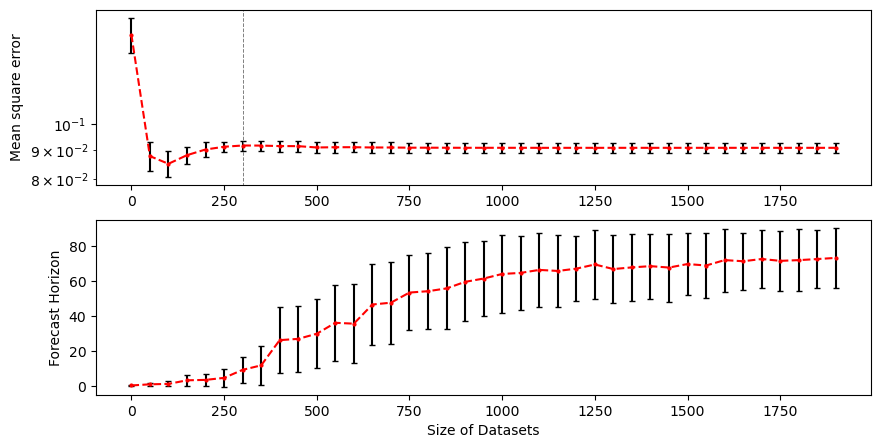

In [15]:
# np.save("avg_mse_Rossler.npy", avg_mse)
# np.save("avg_forecasth_Rossler.npy", avg_forecasth)

# plt.yscale('log')
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
# fig.tight_layout()

# ax[0].plot(np.array(range(samps))*sampr, np.mean(avg_mse, axis=0), label='Averaged Training Loss')
ax[0].errorbar(np.array(range(samps))*sampr, np.mean(avg_mse, axis=0), yerr=np.std(avg_mse, axis=0), capsize=2, markersize=2, fmt="r--o", ecolor = "black")
ax[0].set_ylabel("Mean square error")
# ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_xlim(-200, 1000)

# ax[1].plot(np.array(range(samps))*sampr, np.mean(avg_forecasth, axis=0), label='Averaged Forecast Horizon')
ax[1].errorbar(np.array(range(samps))*sampr, np.mean(avg_forecasth, axis=0), yerr=np.std(avg_forecasth, axis=0), capsize=2, markersize=2, fmt="r--o", ecolor = "black")
ax[1].set_xlabel('Size of Datasets')
ax[1].set_ylabel('Forecast Horizon')
# ax[1].set_yscale('log')
# ax[1].set_xlim(-200, 1000)

print(f'T = {(train_len-sp)*dt_data}, dt = {dt_data:.3f}, n = {train_len-sp}')

for i in range(avg_mse.shape[1]):
    if i>0 and i<(avg_mse.shape[1]-1):
        if abs(np.mean(avg_mse, axis=0)[i]-np.mean(avg_mse, axis=0)[i-1])<0.01*np.mean(avg_mse, axis=0)[i] and abs(np.mean(avg_mse, axis=0)[i]-np.mean(avg_mse, axis=0)[i+1])<0.01*np.mean(avg_mse, axis=0)[i]:
            print(f'MSE saturates at n = {i*sampr}, actual time t = {i*sampr*dt_data:.3f} with error = {np.mean(avg_mse, axis=0)[i]:.5f}.')
            break

ax[0].vlines(i*sampr, 0, 1, color='grey', linestyle='--', linewidth=0.7)
fig.show()
# fig.savefig("Loss Horizon-Data Size_100 BS", dpi=300)


In [129]:
print(np.mean(avg_mse, axis=0))

[0.28240015 0.22986596 0.20331539 0.23131491 0.25757114 0.24725645
 0.12504454 0.05715101 0.02834952 0.01636007 0.01094455 0.00906018
 0.00730437 0.00616449 0.00592748 0.00557873 0.00506578 0.00439241
 0.00444327 0.00444697 0.00444275 0.00402533 0.00362208 0.0035129
 0.00360013 0.00344548 0.00362566 0.00362337 0.00355571 0.0036711
 0.00347104 0.00322348 0.00306503 0.00304153 0.00309592 0.00286698
 0.00272116 0.00258968 0.00249822 0.00237702 0.00227728 0.00234324
 0.00237161 0.00229415 0.00227529 0.00227956 0.00225703 0.00224392
 0.00224974 0.00222968 0.00222086 0.00220838 0.00218768 0.00215939
 0.00211771 0.00208657 0.00204434 0.00199345 0.00193464 0.00187529
 0.00179752 0.00177084 0.00175777 0.0017447  0.00172252 0.00171261
 0.00169084 0.0016789  0.00166675 0.00165579 0.00163318 0.00162752
 0.00160114 0.00159793 0.00157847 0.00153869 0.00162821 0.0014839
 0.00148667 0.001453   0.00144301 0.00144365 0.00144133 0.00143526
 0.00144437 0.00144551 0.00144498 0.0014458  0.00144664 0.0014445